In [1]:
# This notebook is going to use the pipeline and try and evaluate the classic method on many features
# you must first run /scripts/generate_dataset.py to use this

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.model_selection import train_test_split

In [3]:
DATA_DIR = "../data/Challenge_DataSet"
features_dataset = pd.read_csv(f"{DATA_DIR}/features_dataset.csv")
features_dataset

,file_index,file_path,composer,dataset,frame_start,frame_end,frame_id,pitch_range,pitch_entropy,dominant_pitch,...,variance_duration,syncopation,interval_variance,chord_identification,consonance_dissonance,spectral_centroid,spectral_bandwidth,tonality,repetitive_patterns,frame_context
0,0,/workspaces/ClassicalComposer/data/Challenge_D...,Bach,PS1,0,3000,0_0_3000,29,2.722421,52,...,4688.667969,0,0.237654,0.0,0.0,0.000000,1.642862e-09,0.0,0.0,0.0
1,0,/workspaces/ClassicalComposer/data/Challenge_D...,Bach,PS1,19542,22542,0_19542_22542,26,2.505219,43,...,25624.136719,19,0.358025,0.0,0.0,-0.000051,1.518239e-01,0.0,0.0,0.0
2,0,/workspaces/ClassicalComposer/data/Challenge_D...,Bach,PS1,6028,9028,0_6028_9028,17,2.451387,53,...,6468.074219,0,0.168367,0.0,0.0,0.000000,1.642862e-09,0.0,0.0,0.0
3,0,/workspaces/ClassicalComposer/data/Challenge_D...,Bach,PS1,8378,11378,0_8378_11378,29,2.685566,55,...,5338.933594,0,0.249307,0.0,0.0,0.000000,1.642862e-09,0.0,0.0,0.0
4,0,/workspaces/ClassicalComposer/data/Challenge_D...,Bach,PS1,6073,9073,0_6073_9073,17,2.448916,53,...,6518.839844,0,0.168367,0.0,0.0,0.000000,1.642862e-09,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5033,228,/workspaces/ClassicalComposer/data/Challenge_D...,unknown,PS2,5556,8556,228_5556_8556,49,3.186370,65,...,37958.416443,55,0.564043,0.0,0.0,-0.000066,1.717016e-01,0.0,0.0,0.0
5034,228,/workspaces/ClassicalComposer/data/Challenge_D...,unknown,PS2,6191,9191,228_6191_9191,48,3.106434,63,...,38539.536865,61,0.301038,0.0,0.0,-0.000062,1.724332e-01,0.0,0.0,0.0
5035,228,/workspaces/ClassicalComposer/data/Challenge_D...,unknown,PS2,1382,4382,228_1382_4382,46,2.932296,58,...,61261.763428,52,0.869822,0.0,0.0,-0.000069,1.680923e-01,0.0,0.0,0.0
5036,228,/workspaces/ClassicalComposer/data/Challenge_D...,unknown,PS2,15386,18386,228_15386_18386,53,3.144672,58,...,42748.962646,77,0.600586,0.0,0.0,-0.000092,1.747112e-01,0.0,0.0,0.0


In [4]:
# A few helper functions

def stratified_group_split(df, group_col, stratify_col, test_size=0.2, random_state=42):
    """
    Splits a dataset into train and test sets, ensuring all rows with the same group_col value
    are in one set or the other, stratified by stratify_col.

    Args:
        df: DataFrame containing the dataset.
        group_col: Column name that identifies groups (e.g., file_idx).
        stratify_col: Column name for stratification (e.g., composer).
        test_size: Proportion of the dataset to include in the test split.
        random_state: Random seed for reproducibility.

    Returns:
        train_df: Training subset of the DataFrame.
        test_df: Testing subset of the DataFrame.
    """
    # Group by `group_col` and retain a single representative row for each group
    group_df = df.groupby(group_col).first().reset_index()

    # Perform stratified split on the grouped data
    train_groups, test_groups = train_test_split(
        group_df[group_col],  # Split by group_col values
        test_size=test_size,
        random_state=random_state,
        stratify=group_df[stratify_col]  # Stratify by the stratify_col
    )

    # Map the split back to the original dataset
    train_df = df[df[group_col].isin(train_groups)]
    test_df = df[df[group_col].isin(test_groups)]

    return train_df, test_df


def plot_feature_distributions(df, features, labels):
    """
    Plot feature distributions for each cluster using kernel density estimation.

    Args:
        df: DataFrame containing the feature data and cluster labels.
        features: List of feature column names to plot.
        labels: Label assignments for each sample.
    """
    df = df.copy()
    df['label'] = labels  # Add cluster labels to DataFrame

    num_features = len(features)
    fig, axes = plt.subplots(num_features, 1, figsize=(10, 6 * num_features), sharex=False)

    if num_features == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one feature

    for i, feature in enumerate(features):
        for label in sorted(df['label'].unique()):
            sns.kdeplot(
                df.loc[df['label'] == label, feature],
                label=f"{label}",
                ax=axes[i]
            )
        axes[i].set_title(f"Feature Distribution: {feature}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Density")
        axes[i].legend()

    plt.tight_layout()
    plt.show()

In [5]:
"""
PIPELINE
1) Normalize features
2) train kmeans
3) classify with kmeans
4) visualize_clusters
5) calculate_threshold for unknown composers
6) evaluate_and_test_kmeans (run this pipeline)
"""

'\nPIPELINE\n1) Normalize features\n2) train kmeans\n3) classify with kmeans\n4) visualize_clusters\n5) calculate_threshold for unknown composers\n6) evaluate_and_test_kmeans (run this pipeline)\n'

In [6]:
# 1. Normalize Features
def normalize_features(df, feature_columns):
    scaler = StandardScaler()
    normalized = scaler.fit_transform(df[feature_columns])
    return normalized, scaler

In [7]:
# 2. Train K-Means and Map Clusters to Known Composers
def train_kmeans_with_known_composers(X_train, y_train, n_clusters):
    """
    Train KMeans model and map clusters to composers.

    Args:
        X_train: Training feature matrix.
        y_train: Training labels (actual composers).
        n_clusters: Number of clusters.

    Returns:
        kmeans: Trained KMeans model.
        cluster_mapping: Mapping of clusters to composer labels.
        silhouette: Silhouette score for the clustering.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train)

    # Calculate Silhouette Score
    silhouette = silhouette_score(X_train, kmeans.labels_)

    # Map clusters to composers
    cluster_mapping = {}
    for cluster in range(n_clusters):
        labels_in_cluster = y_train.iloc[kmeans.labels_ == cluster]
        if len(labels_in_cluster) > 0:
            dominant_composer = labels_in_cluster.mode()[0]
            cluster_mapping[cluster] = dominant_composer

    return kmeans, cluster_mapping, silhouette

In [8]:
# 3. Classify Validation/Test Set
def classify_with_kmeans(kmeans, cluster_mapping, X):
    """
    Classify samples based on the closest cluster centroid.

    Args:
        kmeans: Trained KMeans model.
        cluster_mapping: Mapping of clusters to composer labels.
        X: Feature matrix to classify.

    Returns:
        predictions: List of predicted composers based on closest cluster.
        distances: Distance logits for each sample to all cluster centroids.
    """
    distances = kmeans.transform(X)  # Distance to each centroid
    closest_clusters = np.argmin(distances, axis=1)  # Index of closest cluster

    # Map clusters to composers
    predictions = [cluster_mapping.get(cluster, "unknown") for cluster in closest_clusters]

    return predictions, distances


In [9]:
# 4. Visualize Clusters
def visualize_clusters(kmeans, X, y, title, pca=None):
    if pca is None:
        pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(X)
    cluster_centers = pca.transform(kmeans.cluster_centers_)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=y, palette='tab10', legend='full')
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', s=200, label='Centroids', marker='X')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

    return pca

In [10]:

#5. Calculate a threshold based on the mean distance the centroids in the training set
def calculate_threshold(kmeans, X_train, std_multiplier=1.0):
    """
    Calculate a threshold based on the mean distance to centroids in the training set.

    Args:
        kmeans: Trained KMeans model.
        X_train: Training feature matrix.
        std_multiplier: Multiplier for the standard deviation (default=1.0).

    Returns:
        threshold: Calculated threshold for "unknown" classification.
    """
    # Compute distances of training samples to centroids
    distances = kmeans.transform(X_train)
    closest_distances = distances.min(axis=1)  # Distance to the closest centroid

    # Calculate mean and standard deviation of distances
    mean_distance = closest_distances.mean()
    std_distance = closest_distances.std()

    # Set threshold
    threshold = mean_distance + std_multiplier * std_distance
    return threshold

In [11]:
# 6. Evaluate and Test K-Means
def evaluate_and_test_kmeans(
    train_df, validation_df, test_df, feature_columns, n_clusters, threshold=None
):
    """
    Evaluate and test the K-Means clustering model.

    Args:
        train_df: Training dataset with features and labels.
        validation_df: Validation dataset with features and labels.
        test_df: Test dataset with features and labels.
        feature_columns: List of feature columns to use for clustering.
        n_clusters: Number of clusters for KMeans.
        threshold: Distance threshold for identifying unknown samples (optional).

    Returns:
        kmeans: Trained KMeans model.
        cluster_mapping: Mapping of clusters to composer labels.
        validation_df: Updated validation dataset with predictions.
        test_df: Updated test dataset with predictions and "unknown" classification.
        threshold: Calculated or provided threshold for unknown classification.
    """
    # Normalize Features
    X_train, scaler = normalize_features(train_df, feature_columns)
    y_train = train_df['composer']

    X_val = scaler.transform(validation_df[feature_columns])
    y_val = validation_df['composer']

    X_test = scaler.transform(test_df[feature_columns])

   # Train K-Means and Calculate Silhouette Score
    kmeans, cluster_mapping, silhouette = train_kmeans_with_known_composers(X_train, y_train, n_clusters)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette:.4f}")

    # Visualize Known Composers (Training Set)
    pca_model = visualize_clusters(kmeans, X_train, y_train, title='K-Means Clusters (Training Set)')

    # Evaluate on Validation Set
    val_predictions, val_distances = classify_with_kmeans(kmeans, cluster_mapping, X_val)
    validation_df['predicted_composer'] = val_predictions

    
    # Visualize Validation Clusters
    visualize_clusters(kmeans, X_val, val_predictions, title='Validation Set Clustering', pca=pca_model)
    
    print("\n\n------------------------------------------------------------")
    print("Validation Results:")
    # Define all possible composers
    all_composers = ['Bach', 'Beethoven', 'Brahms', 'Schubert']
    # Create the Validation Results table
    validation_results = validation_df.groupby(['composer', 'predicted_composer']).size().unstack(fill_value=0)
    # Reindex to ensure all composers are included
    validation_results = validation_results.reindex(index=all_composers, columns=all_composers, fill_value=0)
    print(validation_results)

    # Validation Metrics
    print("\n\nValidation Classification Report:")
    print(classification_report(y_val, val_predictions, zero_division=0))


    # Test the Unknown Set (Post-Processing)
    test_predictions, test_distances = classify_with_kmeans(kmeans, cluster_mapping, X_test)
    test_df.loc[:, 'predicted_composer'] = test_predictions

    if threshold is None:
        threshold = calculate_threshold(kmeans, X_train, std_multiplier=1.5)

    closest_distances = test_distances.min(axis=1)
    test_df.loc[:, 'is_unknown'] = closest_distances > threshold

    print("\n\n------------------------------------------------------------")
    print("\nTest Results:")
    print(test_df['predicted_composer'].value_counts())

    if threshold is not None:
        print("Unknown Classification Results:")
        print(test_df['is_unknown'].value_counts())

    # Visualize Test Clusters
    visualize_clusters(kmeans, X_test, test_predictions, title='Test Set Clustering', pca=pca_model)

    return kmeans, cluster_mapping, validation_df, test_df, threshold

In [12]:
# Do the train test split ensuring that the frames from a single file are either in the train or
# validation set. Stratify by composer
train_df = features_dataset[features_dataset['dataset'] == 'PS1']  # Filter for training data
train_df, validation_df = stratified_group_split(train_df, "file_index", "composer", test_size=0.2)
test_df = features_dataset[features_dataset['dataset'] == 'PS2']  # Filter for test data
# Print the sizes of the splits
print(f"Train size: {len(train_df)}, Validation size: {len(validation_df)}", f"Test size: {len(test_df)}")
train_df

Train size: 3410, Validation size: 858 Test size: 770


,file_index,file_path,composer,dataset,frame_start,frame_end,frame_id,pitch_range,pitch_entropy,dominant_pitch,...,variance_duration,syncopation,interval_variance,chord_identification,consonance_dissonance,spectral_centroid,spectral_bandwidth,tonality,repetitive_patterns,frame_context
0,0,/workspaces/ClassicalComposer/data/Challenge_D...,Bach,PS1,0,3000,0_0_3000,29,2.722421,52,...,4688.667969,0,0.237654,0.0,0.0,0.000000,1.642862e-09,0.0,0.0,0.0
1,0,/workspaces/ClassicalComposer/data/Challenge_D...,Bach,PS1,19542,22542,0_19542_22542,26,2.505219,43,...,25624.136719,19,0.358025,0.0,0.0,-0.000051,1.518239e-01,0.0,0.0,0.0
2,0,/workspaces/ClassicalComposer/data/Challenge_D...,Bach,PS1,6028,9028,0_6028_9028,17,2.451387,53,...,6468.074219,0,0.168367,0.0,0.0,0.000000,1.642862e-09,0.0,0.0,0.0
3,0,/workspaces/ClassicalComposer/data/Challenge_D...,Bach,PS1,8378,11378,0_8378_11378,29,2.685566,55,...,5338.933594,0,0.249307,0.0,0.0,0.000000,1.642862e-09,0.0,0.0,0.0
4,0,/workspaces/ClassicalComposer/data/Challenge_D...,Bach,PS1,6073,9073,0_6073_9073,17,2.448916,53,...,6518.839844,0,0.168367,0.0,0.0,0.000000,1.642862e-09,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4241,192,/workspaces/ClassicalComposer/data/Challenge_D...,Schubert,PS1,4883,7883,192_4883_7883,49,3.103451,44,...,41521.306580,80,0.190664,0.0,0.0,-0.000065,1.591090e-01,0.0,0.0,0.0
4242,192,/workspaces/ClassicalComposer/data/Challenge_D...,Schubert,PS1,48897,51897,192_48897_51897,60,3.385649,53,...,34742.946228,117,0.280000,0.0,0.0,-0.000312,1.761192e-01,0.0,0.0,0.0
4243,192,/workspaces/ClassicalComposer/data/Challenge_D...,Schubert,PS1,14509,17509,192_14509_17509,52,3.258960,77,...,30497.222595,68,0.403214,0.0,0.0,-0.000029,1.657979e-01,0.0,0.0,0.0
4244,192,/workspaces/ClassicalComposer/data/Challenge_D...,Schubert,PS1,20998,23998,192_20998_23998,58,3.609509,79,...,17792.293884,91,0.102071,0.0,0.0,-0.000066,1.827613e-01,0.0,0.0,0.0


In [13]:
train_df.columns[7:-1].to_list()

['pitch_range',
 'pitch_entropy',
 'dominant_pitch',
 'avg_velocity',
 'velocity_variance',
 'silent_notes_ratio',
 'note_density',
 'mean_duration',
 'variance_duration',
 'syncopation',
 'interval_variance',
 'chord_identification',
 'consonance_dissonance',
 'spectral_centroid',
 'spectral_bandwidth',
 'tonality',
 'repetitive_patterns']

/tmp/ipykernel_23155/2959014864.py:57: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_23155/2959014864.py:57: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_23155/2959014864.py:57: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_23155/2959014864.py:57: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_23155/2959014864.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()
/tmp/ipykernel_23155/2959014864.py:57: UserWarning: Dataset has 0 variance; skipping density

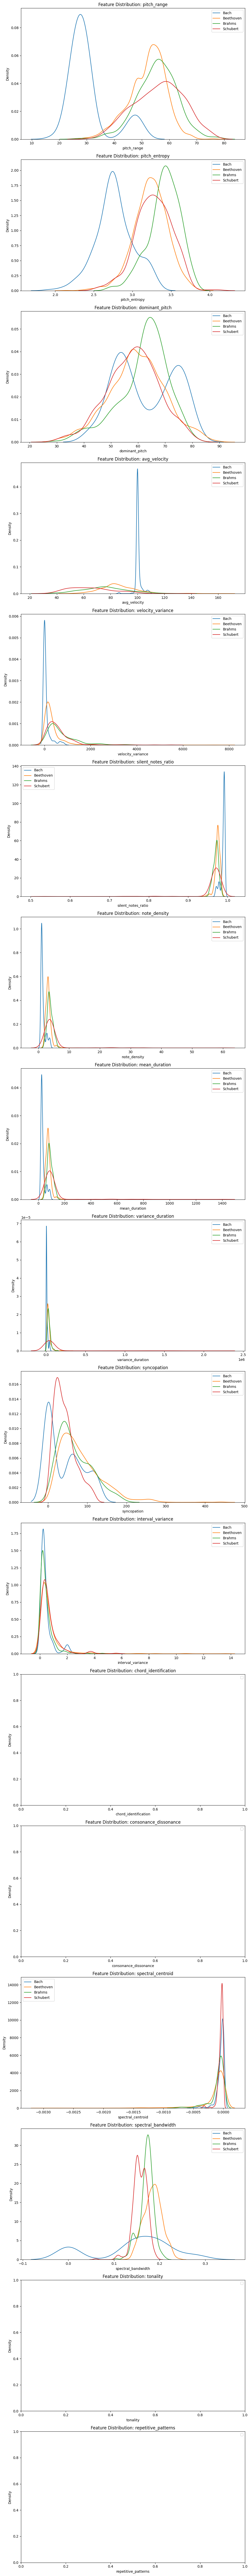

In [14]:
# Plot the feature distributions by cluster

features =['pitch_range',
 'pitch_entropy',
 'dominant_pitch',
 'avg_velocity',
 'velocity_variance',
 'silent_notes_ratio',
 'note_density',
 'mean_duration',
 'variance_duration',
 'syncopation',
 'interval_variance',
 'chord_identification',
 'consonance_dissonance',
 'spectral_centroid',
 'spectral_bandwidth',
 'tonality',
 'repetitive_patterns']
plot_feature_distributions(train_df, features, train_df["composer"])

Silhouette Score for 4 clusters: 0.2250


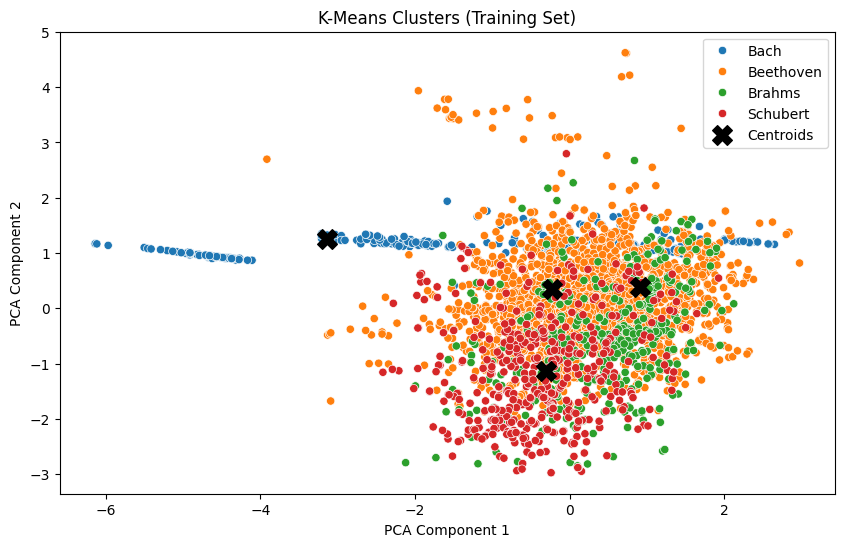

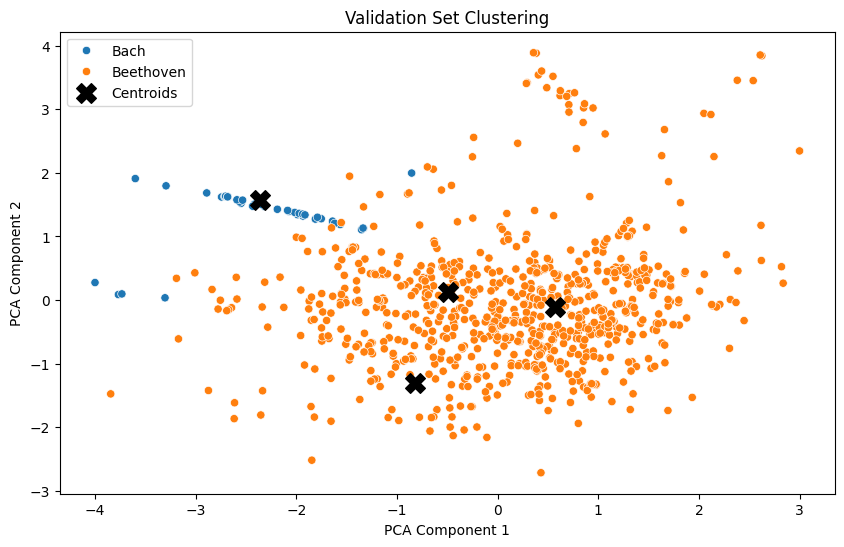



------------------------------------------------------------
Validation Results:
predicted_composer  Bach  Beethoven  Brahms  Schubert
composer                                             
Bach                  44         22       0         0
Beethoven              5        589       0         0
Brahms                 0         88       0         0
Schubert               0        110       0         0


Validation Classification Report:
              precision    recall  f1-score   support

        Bach       0.90      0.67      0.77        66
   Beethoven       0.73      0.99      0.84       594
      Brahms       0.00      0.00      0.00        88
    Schubert       0.00      0.00      0.00       110

    accuracy                           0.74       858
   macro avg       0.41      0.41      0.40       858
weighted avg       0.57      0.74      0.64       858



------------------------------------------------------------

Test Results:
predicted_composer
Beethoven    651
Bach    

/tmp/ipykernel_23155/3021840071.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:, 'predicted_composer'] = test_predictions
/tmp/ipykernel_23155/3021840071.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:, 'is_unknown'] = closest_distances > threshold


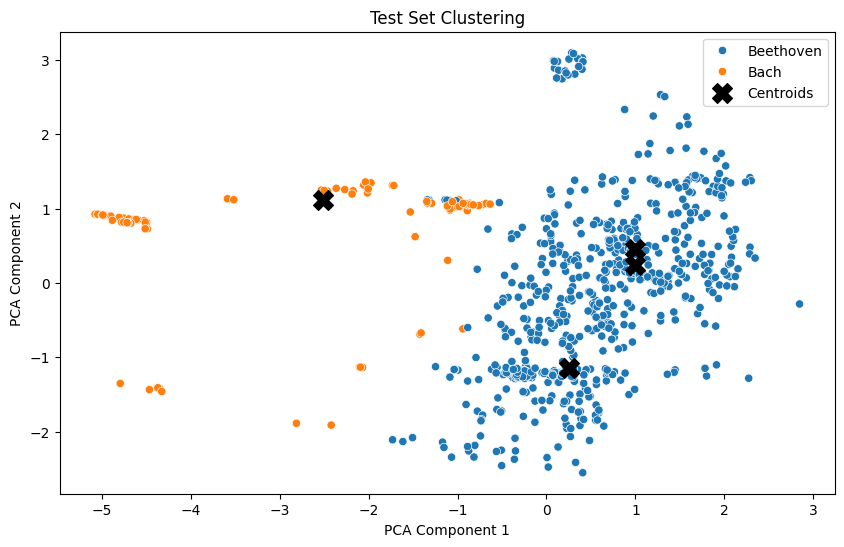

Samples with a distance greater than 2.253363545234315 where classified as `Unknown`
Number of unknown samples: 141


In [15]:
features =[
 # 'pitch_range',
 'pitch_entropy',
 'dominant_pitch',
 'avg_velocity',
 # 'velocity_variance',
 # 'silent_notes_ratio',
 # 'note_density',
 # 'mean_duration',
 # 'variance_duration',
 # 'syncopation',
 # 'interval_variance',
 # 'chord_identification',
 # 'consonance_dissonance',
 # 'spectral_centroid',
 'spectral_bandwidth',
 # 'tonality',
 # 'repetitive_patterns'
]
n_clusters = 4
threshold = None #1.5 Example threshold for unknown classification at test time

kmeans_model, cluster_mapping, validation_results, test_results, threshold_used = evaluate_and_test_kmeans(
    train_df, validation_df, test_df, features, n_clusters, threshold
)

# Analyze "unknown" classification
print(f"Samples with a distance greater than {threshold_used} where classified as `Unknown`")
unknown_samples = test_results[test_results['is_unknown']]
print(f"Number of unknown samples: {len(unknown_samples)}")
